# Data Science Individual Project

Part 1a: Exploratory data analysis

In [393]:
#All imports for future functions
import numpy as np
import pandas as pd
import functools
from scipy import optimize

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [394]:
# Puts data into Dataframe
fish_toxicity = pd.read_csv('qsar_fish_toxicity.csv')
fish_toxicity

,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,X6-MLOGP,Y-LC50
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390
...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109
904,3.652,0.872,0.867,2,3,3.983,4.040
905,3.763,0.916,0.878,0,6,2.918,4.818
906,2.831,1.393,1.077,0,1,0.906,5.317


# Part 1a: Exploratory data analysis

In [395]:
#checks whether any values are missing for each x value
np.isnan(fish_toxicity).any()

# fish_toxicity.isnull() - checks all values to see if null
#fish_toxicity.dropna() - method to drop rows with missing values I think

X1-CIC0         False
X2-SM1_Dz(Z)    False
X3-GATS1i       False
X4-NdsCH        False
X5-NdssC        False
X6-MLOGP        False
Y-LC50          False
dtype: bool

In [396]:
#print 5 rows of table
fish_toxicity.head()

,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,X6-MLOGP,Y-LC50
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [397]:
# number of rows
len(fish_toxicity)

908

In [398]:
# number of columns
len(fish_toxicity.columns)

7

<AxesSubplot:xlabel='X1-CIC0', ylabel='Y-LC50'>

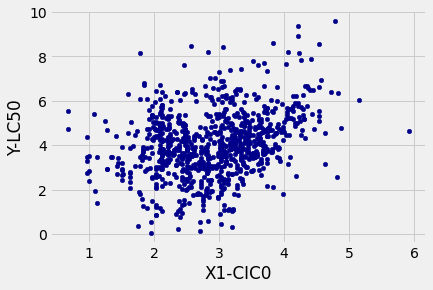

In [399]:
# dependant variable and independant variable
fish_toxicity.plot.scatter('X1-CIC0','Y-LC50', color='DarkBlue')

<AxesSubplot:xlabel='X1-CIC0', ylabel='Y-LC50'>

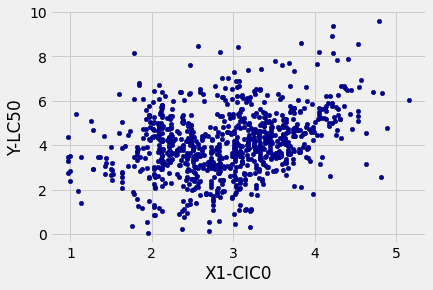

In [400]:
# Remove outliers based on my own judgements
fish_toxicity = fish_toxicity[(fish_toxicity['X1-CIC0'] > 0.7) & (fish_toxicity['X1-CIC0'] <5.5)]
fish_toxicity.plot.scatter('X1-CIC0','Y-LC50', color='DarkBlue')

<AxesSubplot:xlabel='X2-SM1_Dz(Z)', ylabel='X6-MLOGP'>

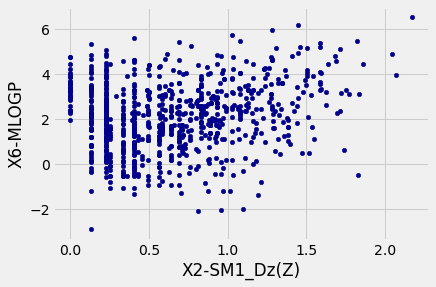

In [401]:
# independant variable and independant variable
fish_toxicity.plot.scatter('X2-SM1_Dz(Z)','X6-MLOGP', color='DarkBlue')

<AxesSubplot:xlabel='X1-CIC0', ylabel='Y-LC50'>

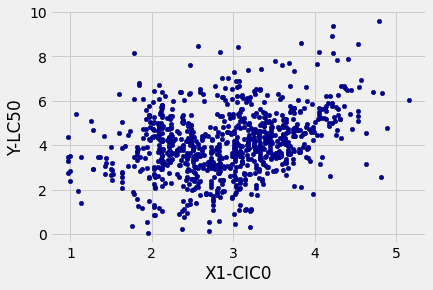

In [402]:
fish_toxicity.plot.scatter('X1-CIC0','Y-LC50', color='DarkBlue')

# Part1b: Standardisation and correlation

In [403]:
#converts value given into standard units
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

#Calculates correlation value
def correlation_cols(x_cols, y_cols):
    #first converts to standard units 
    x_su = standardise(x_cols)
    y_su = standardise(y_cols)
    return np.mean(x_su * y_su)

correlation_cols(fish_toxicity['X1-CIC0'], fish_toxicity['Y-LC50'])

0.3008483525934349

In [404]:
#correlations for all x-values
x_values = ['X1-CIC0','X2-SM1_Dz(Z)','X3-GATS1i','X4-NdsCH','X5-NdssC','X6-MLOGP']
all_correlations = np.array([])
for i in np.arange (len(fish_toxicity.columns)-1):
    #adds correlation for each dependent variable to array
    correlation_found = correlation_cols(fish_toxicity.iloc[:,i], fish_toxicity['Y-LC50'])
    all_correlations = np.append(all_correlations,correlation_found)

#converts to dataframe and sorts by correlation
correlations_df = pd.DataFrame({"x-values": x_values,"All correlations": all_correlations})
correlations_df.sort_values(by='All correlations', ascending=False, key=abs)

,x-values,All correlations
5,X6-MLOGP,0.656267
1,X2-SM1_Dz(Z),0.411210
2,X3-GATS1i,-0.398083
0,X1-CIC0,0.300848
4,X5-NdssC,0.173793
3,X4-NdsCH,0.172969


# Part 1c: Simple regression - Nearest Neighbour & Least Squares

In [405]:
#ft stands for fish_toxicity, included when ft specific
#Takes x_cols to compute NN algorithm
def nearest_neighbour_ft(x_cols):
    #adds all valid x_values from ft to neighbours df
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_cols-0.25)) & (fish_toxicity['X1-CIC0'] <= (x_cols+0.25))]
    return np.mean(neighbours['Y-LC50'])

#overrides prev, computes correlations with table in parameters
def correlation(t, x, y):
    x_su = standardise(t[x])
    y_su = standardise(t[y])
    return np.mean(x_su * y_su)

#performs calculation for slope at any x or y value
def slope(t, x, y):
    r = correlation(t, x, y)
    return r*(np.std(t[y])/np.std(t[x]))

#performs calculation for y intercept using any x or y value
def intercept(t, x, y):
    return np.mean(t[y]) - (slope(t, x, y)*np.mean(t[x]))

#ls stands for least squares
#creates regression line using any x and y values
def fitted_values_ls(t, x, y):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t[x]+b

## Least Squares to table

In [406]:
# Adds predictions for Y-LC50 using Least Squares algorithm with X1-CIC0
values = fitted_values(fish_toxicity,'X1-CIC0','Y-LC50')
fish_toxicity['Y-LC50 - Least Squares X1-CIC0'] = np.array(values)
fish_toxicity


<ipython-input-406-e4cbe6e4c0a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Least Squares X1-CIC0'] = np.array(values)


,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,X6-MLOGP,Y-LC50,Y-LC50 - Least Squares X1-CIC0
0,3.260,0.829,1.676,0,1,1.453,3.770,4.273880
1,2.189,0.580,0.863,0,0,1.348,3.115,3.642261
2,2.125,0.638,0.831,0,0,1.348,3.531,3.604517
3,3.027,0.331,1.472,1,0,1.807,3.510,4.136469
4,2.094,0.827,0.860,0,0,1.886,5.390,3.586235
...,...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109,4.003186
904,3.652,0.872,0.867,2,3,3.983,4.040,4.505061
905,3.763,0.916,0.878,0,6,2.918,4.818,4.570523
906,2.831,1.393,1.077,0,1,0.906,5.317,4.020878


## Nearest Neighbour

In [407]:
#creates new column within fish_toxicity containing results of nn
nn_results = map(nearest_neighbour_ft, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))
fish_toxicity

<ipython-input-407-f87bc4556a1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))


,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,X6-MLOGP,Y-LC50,Y-LC50 - Least Squares X1-CIC0,Y-LC50 - Nearest Neighbour X1-CIC0
0,3.260,0.829,1.676,0,1,1.453,3.770,4.273880,4.032958
1,2.189,0.580,0.863,0,0,1.348,3.115,3.642261,3.869518
2,2.125,0.638,0.831,0,0,1.348,3.531,3.604517,3.972799
3,3.027,0.331,1.472,1,0,1.807,3.510,4.136469,3.910361
4,2.094,0.827,0.860,0,0,1.886,5.390,3.586235,3.996494
...,...,...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109,4.003186,3.637951
904,3.652,0.872,0.867,2,3,3.983,4.040,4.505061,4.438355
905,3.763,0.916,0.878,0,6,2.918,4.818,4.570523,4.486773
906,2.831,1.393,1.077,0,1,0.906,5.317,4.020878,3.669040


In [408]:
fish_toxicity['X1-CIC0'] >= 2.5

0       True
1      False
2      False
3       True
4      False
       ...  
903     True
904     True
905     True
906     True
907     True
Name: X1-CIC0, Length: 905, dtype: bool

# Residuals - NN and LS

In [409]:
def residuals_least_squares(t, x, y):
    predictions = fitted_values(t, x, y)
    return t[y] - predictions

def residuals_NN(t, x, y):
    return t['Y-LC50'] - t['Y-LC50 - Nearest Neighbour X1-CIC0']

In [410]:
#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy().drop(columns=['X6-MLOGP'])
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
ft_residuals

,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,Y-LC50,Y-LC50 - Least Squares X1-CIC0,Y-LC50 - Nearest Neighbour X1-CIC0,Residuals - Nearest Neighbours
0,3.260,0.829,1.676,0,1,3.770,4.273880,4.032958,-0.262958
1,2.189,0.580,0.863,0,0,3.115,3.642261,3.869518,-0.754518
2,2.125,0.638,0.831,0,0,3.531,3.604517,3.972799,-0.441799
3,3.027,0.331,1.472,1,0,3.510,4.136469,3.910361,-0.400361
4,2.094,0.827,0.860,0,0,5.390,3.586235,3.996494,1.393506
...,...,...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,3.109,4.003186,3.637951,-0.528951
904,3.652,0.872,0.867,2,3,4.040,4.505061,4.438355,-0.398355
905,3.763,0.916,0.878,0,6,4.818,4.570523,4.486773,0.331227
906,2.831,1.393,1.077,0,1,5.317,4.020878,3.669040,1.647960


In [411]:
np.mean(ft_residuals['Residuals - Nearest Neighbours'])

-0.0009252048178863456

In [412]:
#Residuals for Least Squares
residuals = residuals_least_squares(fish_toxicity,'X1-CIC0','Y-LC50')
ft_residuals['Residuals - Least Squares'] = np.array(residuals)
ft_residuals

,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,Y-LC50,Y-LC50 - Least Squares X1-CIC0,Y-LC50 - Nearest Neighbour X1-CIC0,Residuals - Nearest Neighbours,Residuals - Least Squares
0,3.260,0.829,1.676,0,1,3.770,4.273880,4.032958,-0.262958,-0.503880
1,2.189,0.580,0.863,0,0,3.115,3.642261,3.869518,-0.754518,-0.527261
2,2.125,0.638,0.831,0,0,3.531,3.604517,3.972799,-0.441799,-0.073517
3,3.027,0.331,1.472,1,0,3.510,4.136469,3.910361,-0.400361,-0.626469
4,2.094,0.827,0.860,0,0,5.390,3.586235,3.996494,1.393506,1.803765
...,...,...,...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,3.109,4.003186,3.637951,-0.528951,-0.894186
904,3.652,0.872,0.867,2,3,4.040,4.505061,4.438355,-0.398355,-0.465061
905,3.763,0.916,0.878,0,6,4.818,4.570523,4.486773,0.331227,0.247477
906,2.831,1.393,1.077,0,1,5.317,4.020878,3.669040,1.647960,1.296122


In [413]:
np.mean(ft_residuals['Residuals - Nearest Neighbours'])

-0.0009252048178863456

In [414]:
np.sum(ft_residuals['Residuals - Nearest Neighbours'])

-0.8373103601872067

In [415]:
correlation(ft_residuals,'Y-LC50 - Nearest Neighbour X1-CIC0','Residuals - Nearest Neighbours')

0.021169555089992374

In [416]:
correlation(ft_residuals,'X1-CIC0','Residuals - Nearest Neighbours')

0.013149260879647188

In [417]:
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

1.344595558509845

In [418]:
np.std(ft_residuals['Residuals - Nearest Neighbours'])

1.3445952401970078

In [419]:
np.mean(ft_residuals['Residuals - Least Squares'])

-5.976802846379849e-16

In [420]:
np.sum(ft_residuals['Residuals - Least Squares'])

-5.364597654988756e-13

In [421]:
correlation(ft_residuals,'Y-LC50 - Least Squares X1-CIC0','Residuals - Least Squares')

1.840148659599707e-16

In [422]:
correlation(ft_residuals,'X1-CIC0','Residuals - Least Squares')

2.0855018142130013e-16

In [423]:
#RMSE is cost function a.k.a evaluates accuracy of results
RMSE = np.mean(ft_residuals['Residuals - Least Squares'] ** 2) ** 0.5
RMSE

1.3886982435674164

In [424]:
np.std(ft_residuals['Residuals - Least Squares'])

1.3886982435674164

## Nearest Neighbour tests

In [425]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.25)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.25))]
    return np.mean(neighbours['Y-LC50'])

#Residuals for Nearest Neighbour
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

1.344595558509845

In [426]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.15)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.15))]
    return np.mean(neighbours['Y-LC50'])

nn_results = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-426-a5398f7949c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))


1.33707599869043

In [427]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.001)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.001))]
    return np.mean(neighbours['Y-LC50'])

nn_results = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-427-4cf5ff8f0a76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))


0.7990946622496785

In [348]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.05)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.05))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-348-c9c7d7a9bf49>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


1.328145043307575

In [349]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val)) & (fish_toxicity['X1-CIC0'] <= (x_val))]
    return np.mean(neighbours['Y-LC50'])

nn_results = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-349-41277364b846>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))


0.695114834738583

In [390]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val - 0.6)) & (fish_toxicity['X1-CIC0'] <= (x_val - 0.6))]
    return np.mean(neighbours['Y-LC50'])

nn_results = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-390-ab1fb33f2990>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(nn_results))


2.002683883294444

In [351]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.03)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.03))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-351-bb29f9a9c4ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


1.2991426709010871

In [352]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.01)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.01))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-352-6c3b45d53783>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


1.1844621276361893

In [353]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.005)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.005))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-353-78b805f76bfd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


1.0643579856848473

In [354]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.002)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.002))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-354-042efa07564e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


0.882043548827364

In [355]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.003)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.003))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-355-d993dd19759d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


0.9838766492763217

In [356]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.004)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.004))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

<ipython-input-356-aceceb312f37>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


1.0292083443330518

In [357]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.35)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.35))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
np.mean(ft_residuals['Residuals - Nearest Neighbours'])

<ipython-input-357-8e72706e7c41>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


0.007889963497267852

In [358]:
def nearest_neighbour(x_val):
    neighbours = fish_toxicity[(fish_toxicity['X1-CIC0'] >= (x_val-0.3)) & (fish_toxicity['X1-CIC0'] <= (x_val+0.3))]
    return np.mean(neighbours['Y-LC50'])

examp = map(nearest_neighbour, fish_toxicity['X1-CIC0'])
fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))

#Residuals for Nearest Neighbour
ft_residuals=fish_toxicity.copy()
ft_residuals['Residuals - Nearest Neighbours'] = list(residuals_NN(fish_toxicity,'X1-CIC0','Y-LC50'))
np.mean(ft_residuals['Residuals - Nearest Neighbours'])

<ipython-input-358-26eb497cac33>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_toxicity['Y-LC50 - Nearest Neighbour X1-CIC0'] = np.array(list(examp))


0.0014317103035018958

## Scatter plots of Residuals and prediction lines

<AxesSubplot:xlabel='X1-CIC0', ylabel='Residuals - Nearest Neighbours'>

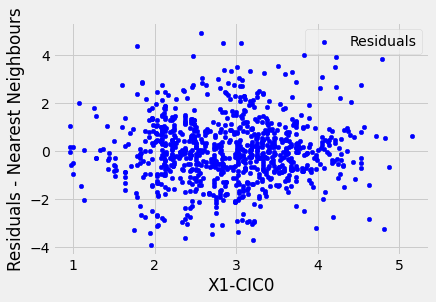

In [359]:
# Scatter plot of residuals
ft_residuals.plot.scatter('X1-CIC0','Residuals - Nearest Neighbours', color='blue', label='Residuals')

KeyError: 'Residuals - Least Squares'

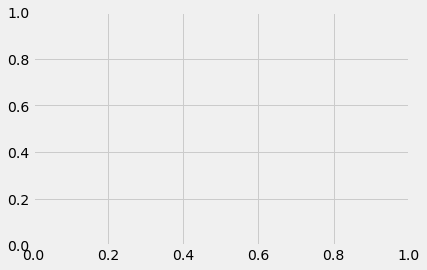

In [428]:
ft_residuals.plot.scatter('X1-CIC0','Residuals - Least Squares', color='blue', label='Residuals')

In [ ]:
# Nearest Neighbour Predictions
ax = fish_toxicity.plot.scatter('X1-CIC0', 'Y-LC50', color='blue', label='y')
fish_toxicity.plot.scatter('X1-CIC0', 'Y-LC50 - Nearest Neighbour X1-CIC0', color='LightGreen', label='Nearest Neighbour', ax=ax)

<AxesSubplot:xlabel='X1-CIC0', ylabel='Y-LC50 - Least Squares X1-CIC0'>

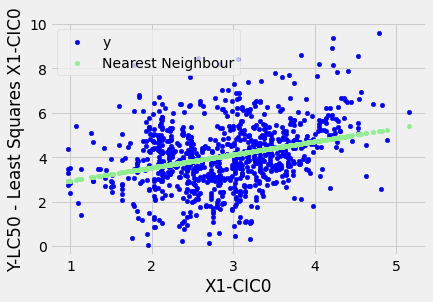

In [336]:
ax = fish_toxicity.plot.scatter('X1-CIC0', 'Y-LC50', color='blue', label='y')
fish_toxicity.plot.scatter('X1-CIC0', 'Y-LC50 - Least Squares X1-CIC0', color='LightGreen', label='Nearest Neighbour', ax=ax)

In [337]:
# Demo of residual properties
np.mean(ft_residuals)

X1-CIC0                               2.899714e+00
X2-SM1_Dz(Z)                          6.286221e-01
X3-GATS1i                             1.293528e+00
X4-NdsCH                              2.298343e-01
X5-NdssC                              4.872928e-01
X6-MLOGP                              2.108024e+00
Y-LC50                                4.061402e+00
Y-LC50 - Least Squares X1-CIC0        4.061402e+00
Y-LC50 - Nearest Neighbour X1-CIC0    4.062327e+00
Residuals - Nearest Neighbours       -9.252048e-04
Residuals - Least Squares            -5.976803e-16
dtype: float64

In [338]:
slopes = slope(fish_toxicity,'X1-CIC0','Y-LC50')
slopes

0.5897472584353254

In [339]:
intercepts = intercept(fish_toxicity,'X1-CIC0','Y-LC50')
intercepts

2.351303938979474

In [340]:
def fish_rmse(any_slope, any_intercept):
    x = fish_toxicity['X1-CIC0']
    y = fish_toxicity['Y-LC50']
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

fish_slope = slope(fish_toxicity,'X1-CIC0','Y-LC50')
fish_intercept = intercept(fish_toxicity,'X1-CIC0','Y-LC50')
result = fish_rmse(fish_slope, fish_intercept)
result

1.3886982435674164

In [143]:
RMSE = np.mean(ft_residuals['Residuals - Nearest Neighbours'] ** 2) ** 0.5
RMSE

1.0292083443330518

In [144]:
RMSE = np.mean(ft_residuals['Residuals - Least Squares'] ** 2) ** 0.5
RMSE

1.3886982435674164

# Part 1d: Multiple Regression

## K Nearest Neighbour

In [430]:
#returns euclidean distance between two points
def euclidean_distance(x1, x2):
    return np.sqrt(sum((x1 - x2)**2))

#returns new df of all distances from all x inputs, and target being the dependent variable
def distances(training, example,target):
    distances = np.array([])
    x_values = training.copy().drop(columns=[target])
    #adds all distances to array
    for row in np.arange(len(x_values)):
        distances = np.append(distances, euclidean_distance(x_values.iloc[row,:], example))

    training['Distance_to_ex'] = distances
    return training

#gets k shortest distances from neighbours
def closest(training, example,target, k):
    return distances(training, example,target).sort_values(by=['Distance_to_ex'], kind='mergesort').take(np.arange(k))

#returns average of top k value
def average_outcome(k_at_top, target):
    return np.mean(k_at_top[target])

##returns average of y values in k instances
def kNN_model(training, example,target, k):
    return average_outcome(closest(training, example,target, k),target)

# evaluates accuracy of prediction made using knn
def evaluate_accuracy(training, test,target, k):
    test_attributes = test.copy().drop(columns=[target])
    prediction = np.array([])
    
    num_correct = 0
    
    for i in np.arange(len(test)):
        c = kNN_model(training, test_attributes.iloc[i,:],target, k)
        prediction = np.append(prediction, c)
        training.drop(columns=['Distance_to_ex'], inplace=True) # remove the extra distance column after every prediction
    
    residual = test[target] - prediction
    #insert into RMSE
    return np.sqrt(np.mean(residual**2))

In [431]:
x1_y = pd.DataFrame({'X1-CIC0':fish_toxicity['X1-CIC0'],
                        'X2-SM1_Dz(Z)':fish_toxicity['X2-SM1_Dz(Z)'],
                        'Y-LC50':fish_toxicity['Y-LC50']})
x1_y

,X1-CIC0,X2-SM1_Dz(Z),Y-LC50
0,3.260,0.829,3.770
1,2.189,0.580,3.115
2,2.125,0.638,3.531
3,3.027,0.331,3.510
4,2.094,0.827,5.390
...,...,...,...
903,2.801,0.728,3.109
904,3.652,0.872,4.040
905,3.763,0.916,4.818
906,2.831,1.393,5.317


## Tests

In [387]:
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 5)

0.959376379974533

In [432]:
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 1)

0.5937630784834682

In [433]:
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 3)

0.8429885863896991

In [55]:
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 6)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

0.98796731052223

In [56]:
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 7)   

1.0065676252229796

In [377]:
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 4)

0.9116759334685465

In [62]:
x3_y = pd.DataFrame({'X1-CIC0':fish_toxicity['X1-CIC0'],
                        'X3-GATS1i':fish_toxicity['X3-GATS1i'],
                        'Y-LC50':fish_toxicity['Y-LC50']})

training_set = x3_y.copy()
test_set = x3_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 5)

0.9895102985067051

In [86]:
x3_y = pd.DataFrame({'X1-CIC0':fish_toxicity['X1-CIC0'],
                        'X3-GATS1i':fish_toxicity['X3-GATS1i'],
                        'Y-LC50':fish_toxicity['Y-LC50']})

training_set = x3_y.copy()
test_set = x3_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 6)

1.0186576816757824

In [87]:
x1_y = pd.DataFrame({'X1-CIC0':fish_toxicity['X1-CIC0'],
                        'X4-NdsCH':fish_toxicity['X4-NdsCH'],
                        'Y-LC50':fish_toxicity['Y-LC50']})
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 6) 

1.1714371076486274

In [88]:
x1_y = pd.DataFrame({'X1-CIC0':fish_toxicity['X1-CIC0'],
                        'X5-NdssC':fish_toxicity['X5-NdssC'],
                        'Y-LC50':fish_toxicity['Y-LC50']})
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 6) 

1.1747836383612633

In [89]:
x1_y = pd.DataFrame({'X1-CIC0':fish_toxicity['X1-CIC0'],
                        'X6-MLOGP':fish_toxicity['X6-MLOGP'],
                        'Y-LC50':fish_toxicity['Y-LC50']})
training_set = x1_y.copy()
test_set = x1_y.copy()
evaluate_accuracy(training_set, test_set,'Y-LC50', 6)

0.9510403522922418

## Multiple regression - Least Squares

In [54]:
#minimise tool from lab
def minimize(f, start=None, smooth=False, log=None, array=False, **vargs):
    if start is None:
        assert not array, "Please pass starting values explicitly when array=True"
        arg_count = f.__code__.co_argcount
        assert arg_count > 0, "Please pass starting values explicitly for variadic functions"
        start = [0] * arg_count
    if not hasattr(start, '__len__'):
        start = [start]

    if array:
        objective = f
    else:
        @functools.wraps(f)
        def objective(args):
            return f(*args)

    if not smooth and 'method' not in vargs:
        vargs['method'] = 'Powell'
    result = optimize.minimize(objective, start, **vargs)
    if log is not None:
        log(result)
    if len(start) == 1:
        return result.x.item(0)
    else:
        return result.x
    

In [435]:
def multiple_regression_rmse_ft(a, b, c):
    x1 = fish_toxicity['X1-CIC0']
    x2 = fish_toxicity['X2-SM1_Dz(Z)']
    y = fish_toxicity['Y-LC50']
    prediction = (a * x1) + (b * x2) + c
    mse = np.mean((y - prediction) ** 2)
    return np.mean((y - prediction) ** 2)

In [436]:
best = minimize(multiple_regression_rmse_ft)
best

array([0.82116075, 1.72828314, 0.59383408])

In [437]:
multiple_regression_rmse_ft(best.item(0), best.item(1), best.item(2))

1.4098292083894972

In [438]:
def multiple_regression_rmse(a, b, c):
    x1 = fish_toxicity['X1-CIC0']
    x2 = fish_toxicity['X3-GATS1i']
    y = fish_toxicity['Y-LC50']
    prediction = (a * x1) + (b * x2) + c
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

best = minimize(multiple_regression_rmse)
multiple_regression_rmse(best.item(0), best.item(1), best.item(2))

1.2275568884029713

In [439]:
def multiple_regression_rmse(a, b, c):
    x1 = fish_toxicity['X1-CIC0']
    x2 = fish_toxicity['X4-NdsCH']
    y = fish_toxicity['Y-LC50']
    prediction = (a * x1) + (b * x2) + c
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

best = minimize(multiple_regression_rmse)
multiple_regression_rmse(best.item(0), best.item(1), best.item(2))

1.374285043459024

In [440]:
def multiple_regression_rmse(a, b, c):
    x1 = fish_toxicity['X1-CIC0']
    x2 = fish_toxicity['X5-NdssC']
    y = fish_toxicity['Y-LC50']
    prediction = (a * x1) + (b * x2) + c
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

best = minimize(multiple_regression_rmse)
multiple_regression_rmse(best.item(0), best.item(1), best.item(2))

1.380772542529152

In [441]:
def multiple_regression_rmse(a, b, c):
    x1 = fish_toxicity['X1-CIC0']
    x2 = fish_toxicity['X6-MLOGP']
    y = fish_toxicity['Y-LC50']
    prediction = (a * x1) + (b * x2) + c
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

best = minimize(multiple_regression_rmse)
multiple_regression_rmse(best.item(0), best.item(1), best.item(2))

1.0987103181305875

In [442]:
def fish_toxicity_rmse(a, b, c):
    x = fish_toxicity['X1-CIC0']
    y = fish_toxicity['Y-LC50']
    quadratic_prediction = a * x**2 + b * x + c
    quadratic_mse = np.mean((y - quadratic_prediction) ** 2)
    return np.sqrt(quadratic_mse)

def quadratic_prediction(x,y):
    result = minimize(fish_toxicity_rmse)
    a = result.item(0)
    b = result.item(1)
    c = result.item(2)
    x = fish_toxicity[x]
    return a * x**2 + b*x + c


In [63]:
quadratic_prediction('X1-CIC0','Quadratic Y-LC50 prediction')
fish_toxicity

,X1-CIC0,X2-SM1_Dz(Z),X3-GATS1i,X4-NdsCH,X5-NdssC,X6-MLOGP,Y-LC50,Y-LC50 - Least Squares X1-CIC0,Y-LC50 - Nearest Neighbour X1-CIC0
0,3.260,0.829,1.676,0,1,1.453,3.770,4.267769,4.057012
1,2.189,0.580,0.863,0,0,1.348,3.115,3.665966,3.873263
2,2.125,0.638,0.831,0,0,1.348,3.531,3.630004,3.941392
3,3.027,0.331,1.472,1,0,1.807,3.510,4.136844,3.884946
4,2.094,0.827,0.860,0,0,1.886,5.390,3.612585,3.962767
...,...,...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109,4.009853,3.663522
904,3.652,0.872,0.867,2,3,3.983,4.040,4.488037,4.435573
905,3.763,0.916,0.878,0,6,2.918,4.818,4.550408,4.507947
906,2.831,1.393,1.077,0,1,0.906,5.317,4.026710,3.706634


# Part 1e: Bootstrapping and Confidence Intervals

Predicted y from bootstramp sample was 171.0082234554629


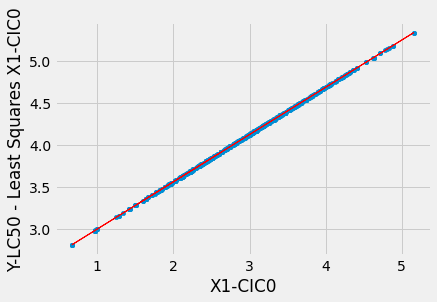

In [64]:
def prediction_at(t, x, y, x_value):
    return slope(t, x, y) * x_value + intercept(t, x, y)

# plots graph using resampled data for the least squared algorithm
resample = fish_toxicity.sample(len(fish_toxicity), replace=True)
predicted_y = prediction_at(resample, 'X1-CIC0', 'Y-LC50 - Least Squares X1-CIC0', 300)
print('Predicted y from bootstramp sample was', predicted_y)

slope_births = slope(resample,'X1-CIC0','Y-LC50 - Least Squares X1-CIC0')
intercept_births = intercept(resample,'X1-CIC0','Y-LC50 - Least Squares X1-CIC0')
yfit = slope_births * resample['X1-CIC0'] + intercept_births

resample.plot.scatter('X1-CIC0','Y-LC50 - Least Squares X1-CIC0')
plt.plot(resample['X1-CIC0'], yfit, lw=1, color='red')

In [74]:
def bootstrap_prediction(t, x, y, new_x, repetitions=1000):

    # collect preditions for resampling
    predictions = np.array([])
    
    for i in np.arange(repetitions):
        resample = t.sample(len(t), replace=True)
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 96% prediction interval
    left = np.percentile(predictions, 2)
    right = np.percentile(predictions, 98)

    # Display for least squares
    pd.DataFrame({'Least Squares Predictions at 2':predictions}).hist(bins=20, ec='black')
    
    plt.xlabel('predictions at x='+str(new_x))
    plt.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 96%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')

Approximate 95%-confidence interval for height of true line:
4.035051616991855 4.220035264925906 (width = 0.1849836479340512 )


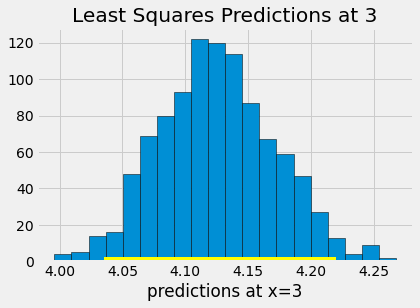

In [73]:
bootstrap_prediction(fish_toxicity, 'X1-CIC0', 'Y-LC50', 3)

Approximate 96%-confidence interval for height of true line:
3.41217917846787 3.710628273477229 (width = 0.29844909500935923 )


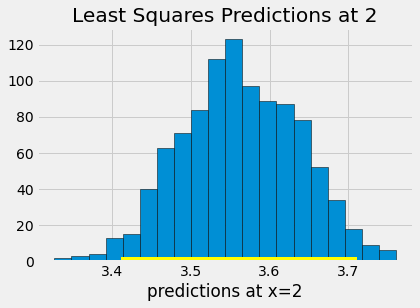

In [75]:
bootstrap_prediction(fish_toxicity, 'X1-CIC0', 'Y-LC50', 2)

In [78]:
# Understand and compare this function with the previous mse_both function, then run this cell
def mse_both_generic(a, b, c, t, x1, x2, y):
    predicted_y = (a * t[x1]) + (b * t[x2]) + c
    errors = t[y] - predicted_y
    return np.mean(errors**2)

def prediction_at_both(t, x1, x2, y, x1_value, x2_value):
    #lambda allows method to be called without all required arguments
    coef = minimize(lambda par1, par2, par3: mse_both_generic(par1, par2, par3, t, x1, x2, y))
    return (coef.item(0) * x1_value) + (coef.item(1) * x2_value) + coef.item(2)

In [378]:
def bootstrap_prediction_both(t, x1, x2, y, new_x1, new_x2, repetitions=1000):

    predictions = np.array([])
    
    for i in np.arange(repetitions):
        #bootstrap sample
        resample = t.sample(len(t), replace=True)
        #makes prediction using multiple regresion method
        predicted_y = prediction_at_both(resample, x1, x2, y, new_x1, new_x2)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 96% prediction interval
    left = np.percentile(predictions, 2)
    right = np.percentile(predictions, 98)

    #Creates histogram using predictions
    pd.DataFrame({'Multiple regression Prediction at 3':predictions}).hist(bins=20, ec='black')
    
    plt.xlabel('predictions at X1-CIC0='+str(new_x1) + ', X2-SM1_Dz(Z)=' +str(new_x2))
    plt.plot([left, right], [0, 0], color='red', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')



Approximate 95%-confidence interval for height of true line:
9.190236220220967 10.668287498253116 (width = 1.478051278032149 )


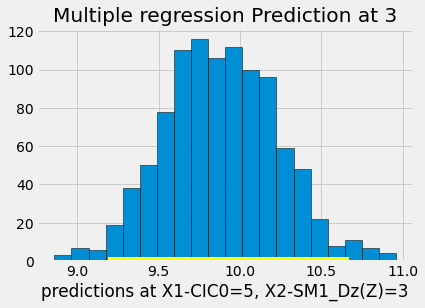

In [379]:
bootstrap_prediction_both(fish_toxicity, 'X1-CIC0', 'X2-SM1_Dz(Z)', 'Y-LC50', 5, 3)